Постановка задачи:
$$\underset{x \in S}{min} \; f(x) = \frac{1}{2} (x, Ax) + (b, x)$$
$$S = \{ x \in \mathbb{R}^n : (x,x) = 1 \}$$

Поскольку аналитически решение такой задачи получить не представляется возможным, решим ее методом сопряженных градиентов:
\begin{equation} 
x^{k+1} = P_S(x^k - \alpha_k p^k) = \frac{x^k - \alpha_k p^k}{\| x^k - \alpha_k p^k \|},
\end{equation}
где $\alpha_k$, $p^k$ определяются следующим образом:
\begin{equation}
\begin{aligned}
\alpha_k &= \underset{\alpha}{argmin} \; f(P_S(x^k + \alpha p^k))  = \\
&= \underset{\alpha}{argmin}\Bigg\{ \frac{1}{2} \frac{(x^k + \alpha p^k, A(x^k + \alpha p^k))}{\| x^k + \alpha p^k \|^2} + \frac{(b, x^k + \alpha p^k)}{\| x^k + \alpha p^k \|} \Bigg\},\; x_0 \in S \\
p^k &= P_S(-\nabla f(x^k) - \beta_k p^{k-1}) = \frac{-(Ax^k + b) - \beta_k p^{k-1}}{\| -(Ax^k + b) - \beta_k p^{k-1} \|}, \; p^0 = -\frac{Ax^0 + b}{\| Ax^0 + b \|}, \\
\beta_k &= \frac{\| P_S(\nabla f(x^k)) \|^2}{\| P_S(\nabla f(x^{k-1}))\|^2} = 1
\end{aligned}
\end{equation}

In [97]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
A = np.array([[1., 1., 1.], [1., -100., 1.], [1., 1., 1.]])
b = np.array([1., 2., 3.])
print A
print b

[[   1.    1.    1.]
 [   1. -100.    1.]
 [   1.    1.    1.]]
[ 1.  2.  3.]


In [45]:
x0 = np.array([0., 0., 1.])
x0 = x0 / np.linalg.norm(x0)
p0 = - (np.dot(A, x0) + b) / (np.linalg.norm(np.dot(A, x0) + b))

In [54]:
def getFuncValue(x):
    return x.dot(np.dot(A, x)) + np.dot(b,x)

In [4]:
def getXkk(xk, alphak, pk):
    return (xk - alphak * pk) / np.linalg.norm(xk - alphak * pk)
def getPkk(pk, xk):
    return (np.dot(-A, xk) - b - pk) / np.linalg.norm(np.dot(-A, xk) - b - pk)
def gradAlpha(xk, pk, alpha):
    first = ((xk + alpha * pk).dot(np.dot(A, pk)) * np.linalg.norm(xk + alpha * pk) ** 2 - 2 * np.dot(xk + alpha * pk, pk) * (xk + alpha * pk).dot(np.dot(A, xk + alpha * pk))) / (np.linalg.norm(xk + alpha * pk) ** 4)
    second = (np.dot(b, pk) * np.linalg.norm(xk + alpha * pk) - (np.dot(xk + alpha * pk, pk))/(np.linalg.norm(xk + alpha * pk)) * np.dot(b, xk + alpha * pk)) / (np.linalg.norm(xk + alpha * pk) ** 2)
    return first + second

Для вычисления шага $\alpha_k$ будем делать градиентный спуск с априорным выбором шага. Последовательность шагов будет такова, что ряд из шагов расходится, а из квадратов сходится.

In [17]:
def getNewAlpha(xk, pk, eps, lRate):
    alphak = 0.
    n = 1
    notEnough = True
    while (notEnough):
        if (1. / n) * gradAlpha(xk, pk, alphak) < eps:
            notEnough = False
        alphakk = alphak -lRate * (1. / n) * gradAlpha(xk, pk, alphak)
        alphak = alphakk
        n = n + 1
        if (n % 100 == 0):
            print 'alpha iternum = ', n
            print 'alphak = ', alphak
    return alphakk

In [18]:
#test cell
alphat = getNewAlpha(x0, p0, 1e-5, 100.)
print alphat
gradalphat = gradAlpha(x0, p0, alphat)
print gradalphat

247.518326397
-0.0281621792352


In [94]:
def sphereCGM(x0, p0, eps, epsalpha, xs, fs):
    notEnough = True
    xk = x0
    pk = p0
    lRate = 1.
    i = 0
    xs.append(x0)
    fs.append(getFuncValue(x0))
    while (notEnough):
        alphak = getNewAlpha(xk, pk, epsalpha, lRate)
        xkk = getXkk(xk, alphak, pk)
        if np.linalg.norm(xkk - xk) < eps:
            notEnough = True
        pk = getPkk(xk, pk)
        
        if (i % 100 == 0):
            print 'x iternum = ', i
            print 'xk = ', xk
            print 'xkk = ', xkk
        xk = xkk
        i = i + 1
        xs.append(xk)
        fs.append(getFuncValue(xk))
        if i > 20: break
    return xk
        
        

In [108]:
x0 = np.array([1., 1., 1.])
x0 = x0 / np.linalg.norm(x0)
p0 = - (np.dot(A, x0) + b) / (np.linalg.norm(np.dot(A, x0) + b))
xs = []
fs = []
print sphereCGM(x0, p0, 1e-2, 1e-2, xs, fs)

x iternum =  0
xk =  [ 0.57735027  0.57735027  0.57735027]
xkk =  [ 0.07322826 -0.99118893  0.11037267]
[ 0.01977454 -0.99899714  0.04017063]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


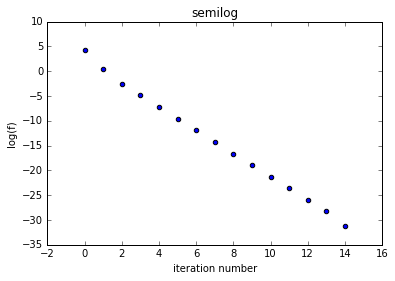

In [109]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()